In [6]:
import sys
!pip install --prefix {sys.prefix} hcp_utils
!pip install --prefix {sys.prefix} nilearn
!pip install --prefix {sys.prefix} nibabel


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [10]:
import hcp_utils as hcp
import numpy as np
import nibabel as nb
import nilearn.plotting as plotting
import matplotlib.pyplot as plt
from scipy import signal
import scipy as sci
import random

# load in subject parcel as template cifti
parcelLoc='C:GroCon.dscalar.nii'
parcel=nb.load(parcelLoc)
parcelCort=parcel.dataobj[:,hcp.struct.cortex]

# load in gradient
gradsf='C:hcp.gradients.dscalar.nii'
grads=nb.load(gradsf)
PG=grads.dataobj[0,hcp.struct.cortex]


vox offset (=1.7029e+06) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=1.7029e+06) not divisible by 16, not SPM compatible; leaving at current value
C:\Users\adam\anaconda3\lib\site-packages\nibabel\nifti1.py:590: UserWarning: Extension size is not a multiple of 16 bytes; Assuming size is correct and hoping for the best
  warnings.warn(
vox offset (=1.7029e+06) not divisible by 16, not SPM compatible; leaving at current value


In [2]:
# initialize a percentile membership vector 
percMemb=np.zeros(len(PG.data))
# get percentiles
for p in range(25):
    # every 4 percent bin (25 * 5)
    percThresh_L=np.percentile(PG.data,(p*4))
    percThresh_U=np.percentile(PG.data,((p+1)*4))
    # label cifti verts falling in this perc bin 
    Indices= np.logical_and(PG.data > percThresh_L, PG.data < percThresh_U)
    percMemb[Indices]=p
    
    
    

In [3]:
# plot percentiles/4 to ensure it is working
plotting.view_surf(hcp.mesh.inflated_right, hcp.right_cortex_data(percMemb), 
    bg_map=hcp.mesh.sulc_right)

vox offset (=1.70334e+06) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=1.70334e+06) not divisible by 16, not SPM compatible; leaving at current value
C:\Users\adam\anaconda3\lib\site-packages\nibabel\nifti1.py:590: UserWarning: Extension size is not a multiple of 16 bytes; Assuming size is correct and hoping for the best
  warnings.warn(
vox offset (=1.70334e+06) not divisible by 16, not SPM compatible; leaving at current value


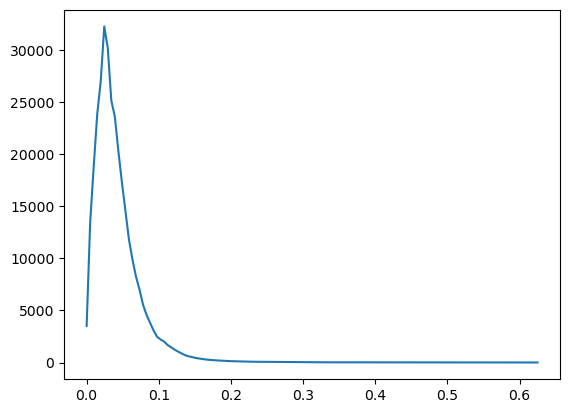

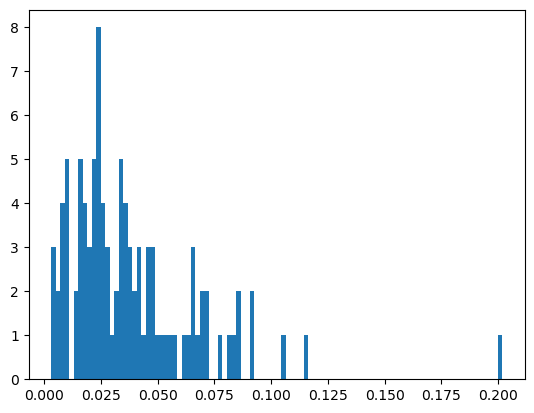

In [54]:
# load in template time series to replace data
templateTS=nb.load('C:/Users/adam/template-rest_p2mm_masked.dtseries.nii')
templateData=templateTS.get_fdata()
# extract cortex
templateDataCort=templateData[:,hcp.struct.cortex]

# sampling frequency
TR=.8
fs=(1/TR)

# control for psuedo-high-frequency power from discontinuous (motion-masked) frames
# see https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=2):
    # parameters matched to real-data pipeline
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Desired cutoff frequencies (in Hz).
lowcut = 0.008
highcut = 0.09
# create filter
butter_bandpass(lowcut, highcut, fs)

# filter data
templateDataCort = butter_bandpass_filter(templateDataCort, lowcut, highcut, fs)

# extract frequency distribution
# get frequency distribution of all vertices
freqs, density = signal.welch(templateDataCort,fs,axis=0)
# average frequency distribution
avgFreqs=density.mean(axis=1)
plt.plot(freqs,avgFreqs)
plt.xlabel('Hz')
plt.xlim(-0.01,0.25)
plt.show()

# extract cumulative distribution, bin widths (https://stackoverflow.com/questions/13476807/probability-density-function-from-histogram-in-python-to-fit-another-histrogram)
cum_counts = np.cumsum(avgFreqs)
bin_widths = np.repeat(freqs[1] - freqs[0],cum_counts.shape[0])
x = cum_counts*bin_widths
y = freqs[0:]

# interpolate density of frequency distribution
inverse_density_function = sci.interpolate.interp1d(x, y)

# use interpolated density to sample realistic frequencies for simulated waves
randFreqs = np.zeros(100)
for i in range(len( randFreqs )):
    u = random.uniform( x[0], x[-1] )
    randFreqs[i] = inverse_density_function( u )

# plot randomly sampled values
plt.hist(randFreqs,100)
plt.xlabel('Randomly Sampled Values from Distr: Hz')
plt.xlim(-0.01,0.25)
plt.show()

In [55]:
### replace template data with sine waves

# initialize a new matrix using template data
SimData=np.zeros(templateDataCort.shape)

# initialize tracker of last-filled TR
LF_TR=0

# for 100 iterations, create a sine wave of realistic frequency
# in each percentile bin
for i in range(100):
    # get realistic frequency
    realisticFreq=randFreqs[i]
    # according to this frequency, how many TRs would this wave take to cycle?
    numTRs=TR/realisticFreq
    # create sine wave of this frequency
    realisticPeriod=np.linspace(-np.pi,np.pi,int(np.round(numTRs)))
    realisticWave=np.sin(realisticPeriod)
    # reverse order of sine wave for EZ interpretation
    realisticWave=realisticWave[::-1]
    # set starting TR for first bin to be 1 TR after where last wave ended
    startTR=LF_TR+1
    # Now distribute it over all gradient bins to match a 20-second procession
    for p in range(25):
        # index vertices in this percentile bin
        thisBin=np.where(percMemb==p)
        # repeat wave to be consistent across all vertices in this bin
        # this is like np.repeat but into a 2d array instead of 1d
        binWave=np.tile([realisticWave],(len(thisBin[0]),1))
        # get ending TR index
        endTR=startTR+len(realisticWave)
        # break loop if end TR is beyond length of time series
        if endTR > templateDataCort.shape[0]:
            break
        # extract frames to index into
        frames=np.arange(startTR,endTR)
        # generate indices that will work to modify SimData
        i1,i2 = np.ix_(frames,thisBin[0])
        # plop realistic wave into next unused TR
        SimData[i1,i2]=np.transpose(binWave)
        # delay 1 TR from previous bin
        startTR=startTR+1
    # record last used TR
    LF_TR=startTR+len(realisticWave)

In [61]:
# need dummy subcortex to save as cifti
OutputData=np.zeros(templateTS.shape)
OutputData[:,hcp.struct.cortex]=SimData
# create cifti from dataframe and templates
timeAxis=nb.cifti2.SeriesAxis(start=0,size=SimData.shape[0],step=1)
spaceAxis=templateTS.header.get_axis(1)
new_img=nb.Cifti2Image(OutputData,(timeAxis,spaceAxis))
filename='C:SimulatedPropagations.dtseries.nii'
new_img.to_filename(filename)

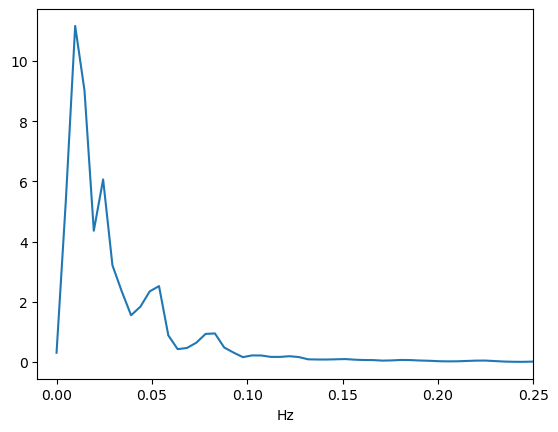

In [60]:
# plot PSD of simulated data
freqs, density = signal.welch(SimData,fs,axis=0)
# average frequency distribution
avgFreqs=density.mean(axis=1)
plt.plot(freqs,avgFreqs)
plt.xlabel('Hz')
plt.xlim(-0.01,0.25)
plt.show()